**Plant Seedling Classification using Convolutional Neural Networks**

First need to add input data, for that click on 'Add Data'. Go to the competitions tab and then search for the 'Plant Seedlings Classification' dataset and add it. This dataset contains a training set and a testing set of images of plant seedlings at various growth stages. Each image has its own unique ID. The dataset has 12 main plant species which we need to classify the testing set into. For this task, first, we processed and cleaned the data using image processing techniques. Then we build a model and evaluate it.

**Import Libraries**

In [1]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

**Import training data set**

In [2]:
train_file_path = '/kaggle/input/plant-seedlings-classification/train/*/*.png'
train_images = glob(train_file_path)

**Preprocess the training images set**

In [3]:
scale_to = 100  # pixel of image to re-scale
num_of_seed = 7  # fixing random seeds

train_img_array = []
train_label_array = []
count = 1
num = len(train_images)

# Image resizing, get all labels
for img in train_images:
    print(str(count) + "/" + str(num), end="\r")
    train_img_array.append(cv2.resize(cv2.imread(img), (scale_to, scale_to)))  # Get image (with resizing)
    img_array = img.split('/')
    train_label_array.append(img_array[5]) # image type
    count += 1

train_images = np.asarray(train_img_array)  # Train images set
train_labels = pd.DataFrame(train_label_array)  # Train labels set

Print proccessed images

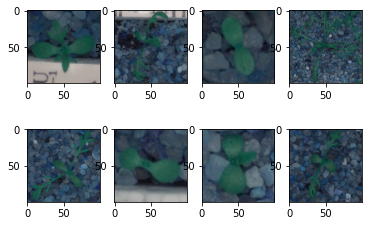

In [4]:
for count in range(8):
    plt.subplot(2, 4, count + 1)
    plt.imshow(train_images[count])

**Clean the training images set**

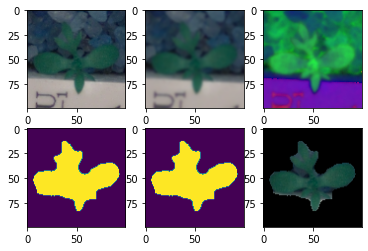

In [5]:
cleaned_train_images = []
show_samples = True
for img in train_images:
    # gaussian blur
    blur_img = cv2.GaussianBlur(img, (5, 5), 0)

    # convert to HSV image
    hsvImg = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HSV)

    # Create mask (parameters - green color range)
    lower_green = (25, 41, 50)
    upper_green = (74, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Create bool mask
    bMask = mask > 0

    # Apply the mask
    cleaned = np.zeros_like(img, np.uint8)  # Create empty image
    cleaned[bMask] = img[bMask]  # Apply boolean mask to the origin image

    cleaned_train_images.append(cleaned)  # Append image without backgroung

    # Show examples
    if show_samples:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blur_img)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(cleaned)  # Image without background
        show_samples = False

cleaned_train_img = np.asarray(cleaned_train_images)

**Print cleaned images**

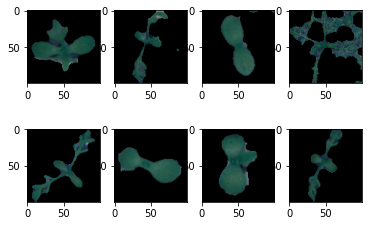

In [6]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(cleaned_train_img[i])

In [7]:
cleaned_train_imgs = cleaned_train_img / 255

**Identify the Classes**

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
num of classes: 12


<AxesSubplot:>

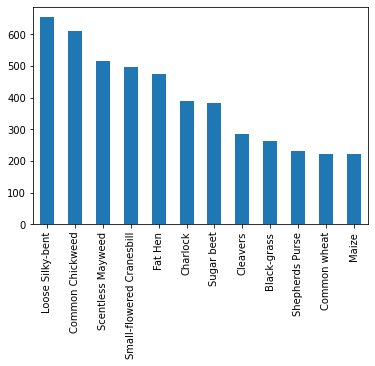

In [8]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(train_labels[0])
print("Classes: " + str(le.classes_))
encode_train_labels = le.transform(train_labels[0])

# Make labels categorical
cleaned_train_label = np_utils.to_categorical(encode_train_labels)
num_classes = cleaned_train_label.shape[1]
print("num of classes: " + str(num_classes))

# Plot of label types numbers
train_labels[0].value_counts().plot(kind='bar')

<AxesSubplot:ylabel='0'>

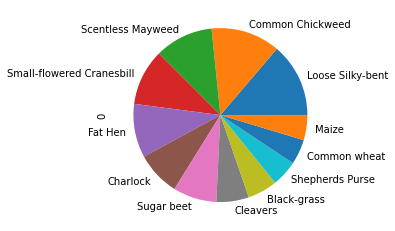

In [9]:
train_labels[0].value_counts().plot(kind='pie')

**Split train and test data set**

In [10]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(cleaned_train_imgs, cleaned_train_label,
                                                test_size=0.2, random_state=num_of_seed,
                                                stratify = cleaned_train_label)

In [11]:
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )
data_gen.fit(trainX)

**Create the Model**

In [12]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

numpy.random.seed(num_of_seed)  # num_of_seed

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale_to, scale_to, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       2

In [13]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.4,
                                            min_lr=0.00001)

# add check points
file_path = "/kaggle/working/weights.best_{epoch:02d}-{val_accuracy:.2f}.hdf5"

check_point = ModelCheckpoint(file_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

file_path = "/kaggle/working/weights.last_auto.hdf5"
checkpoint_all = ModelCheckpoint(file_path, monitor='val_accuracy',
                                 verbose=1, save_best_only=False, mode='max')

# all callbacks
callbacks_list = [check_point, learning_rate_reduction, checkpoint_all]

# fit model
hist = model.fit_generator(data_gen.flow(trainX, trainY, batch_size=75), epochs=30, validation_data=(testX, testY), callbacks=callbacks_list)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
51/51 [==============================] - 75s 1s/step - loss: 3.0351 - accuracy: 0.2073 - val_loss: 25.1081 - val_accuracy: 0.0463

Epoch 00001: val_accuracy improved from -inf to 0.04632, saving model to /kaggle/working/weights.best_01-0.05.hdf5

Epoch 00001: saving model to /kaggle/working/weights.last_auto.hdf5
Epoch 2/30
51/51 [==============================] - 57s 1s/step - loss: 2.0388 - accuracy: 0.3809 - val_loss: 23.2107 - val_accuracy: 0.0463

Epoch 00002: val_accuracy did not improve from 0.04632

Epoch 00002: saving model to /kaggle/working/weights.last_auto.hdf5
Epoch 3/30
51/51 [==============================] - 57s 1s/step - loss: 1.5278 - accuracy: 0.4813 - val_loss: 25.1781 - val_accuracy: 0.0611

Epoch 00003: val_accuracy improved from 0.04632 to 0.06105, saving model to /kaggle/working/weights.best_03-0.06.hdf5

Epoch 00003: saving model to /kaggle/working/weights.last_auto.hdf5
Epoch 4/30
51/51 [==============================] - 57s 1s/step - loss: 1.4965 

In [14]:
model.load_weights("/kaggle/working/weights.last_auto.hdf5")

In [15]:
print(model.evaluate(trainX, trainY))  # evaluate on train set
print(model.evaluate(testX, testY))  # evaluate on test set

119/119 [==============================] - 45s 379ms/step - loss: 0.2981 - accuracy: 0.8921
[0.2981433868408203, 0.8921052813529968]
30/30 [==============================] - 11s 362ms/step - loss: 1.8859 - accuracy: 0.8568
[1.8859095573425293, 0.8568421006202698]


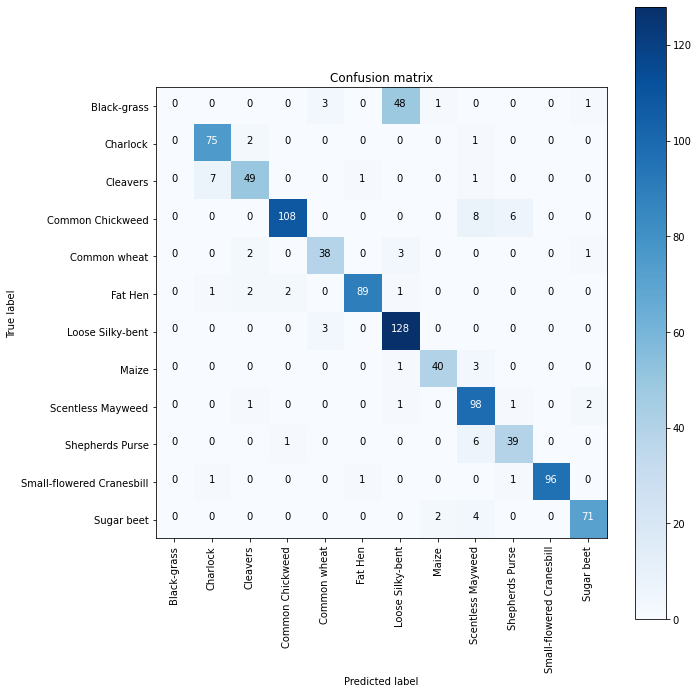

In [16]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):

    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
pred_y = model.predict(testX)
pred_y_classes = np.argmax(pred_y, axis = 1)
true_y = np.argmax(testY, axis = 1)

# confusion matrix
confusion_MTX = confusion_matrix(true_y, pred_y_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_MTX, classes = le.classes_)

In [17]:
test_images_path = '/kaggle/input/plant-seedlings-classification/test/*.png'
test_images = glob(test_images_path)

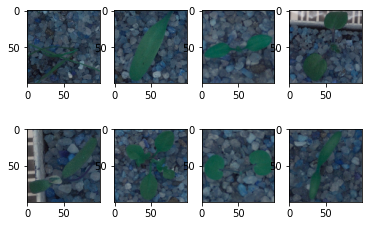

In [18]:
test_img_array = []
test_id_array = []
count = 1
num = len(test_images)

# Obtain images and resizing, obtain labels
for img in test_images:
    print("Obtain images: " + str(count) + "/" + str(num), end='\r')
    img_array = img.split('/')
    test_id_array.append(img_array[5]) # image id
    test_img_array.append(cv2.resize(cv2.imread(img), (scale_to, scale_to)))
    count += 1

test_imgs = np.asarray(test_img_array)  # Train images set

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(test_imgs[i])

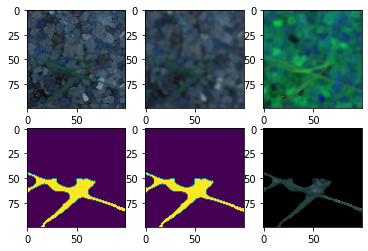

In [19]:
cleaned_test_img = []
show_samples = True
for img in test_imgs:
    # gaussian blur
    blur_img = cv2.GaussianBlur(img, (5, 5), 0)

    # convert to HSV image
    hsvImg = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HSV)

    # create mask (parameters - green color range)
    lower_green = (25, 41, 50)
    upper_green = (74, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # create bool mask
    bMask = mask > 0

    # Apply the mask
    cleaned = np.zeros_like(img, np.uint8)  # Create empty image
    cleaned[bMask] = img[bMask]  # Apply boolean mask to the origin image

    cleaned_test_img.append(cleaned)  # Append image without background

    # Show examples
    if show_samples:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blur_img)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(cleaned)  # Image without background
        show_samples = False

cleaned_test_img = np.asarray(cleaned_test_img)

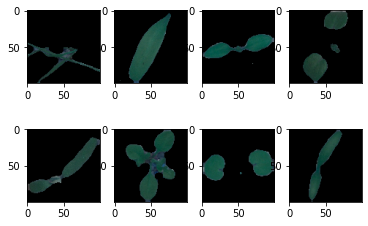

In [20]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(cleaned_test_img[i])

In [21]:
cleaned_test_img = cleaned_test_img / 255

In [22]:
pred = model.predict(cleaned_test_img)

**Create submission**

In [23]:
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': test_id_array, 'species': predStr}
res = pd.DataFrame(res)

In [24]:
res.to_csv("/kaggle/working/result_v2.csv", index=False)